In [1]:
#This is the code that computes the set of payoffs that several players get from designing 
#an information structure to persuade a receiver (https://web.stanford.edu/~gentzkow/research/BayesianPersuasion.pdf)
#My co-author Kemal Kivanc Akoz and I prove related results in our paper "Information agreements"
#(https://drive.google.com/file/d/1JPCdk4TQBxj6O2lzrB2DrGLcvKRmcubN/view)
#The Appendix provides an algorithm used here. 


key library for characterizing extreme points of a convex polygon
pip install pycddlib

import numpy as np
import cdd
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import ConvexHull
from scipy.linalg import block_diag

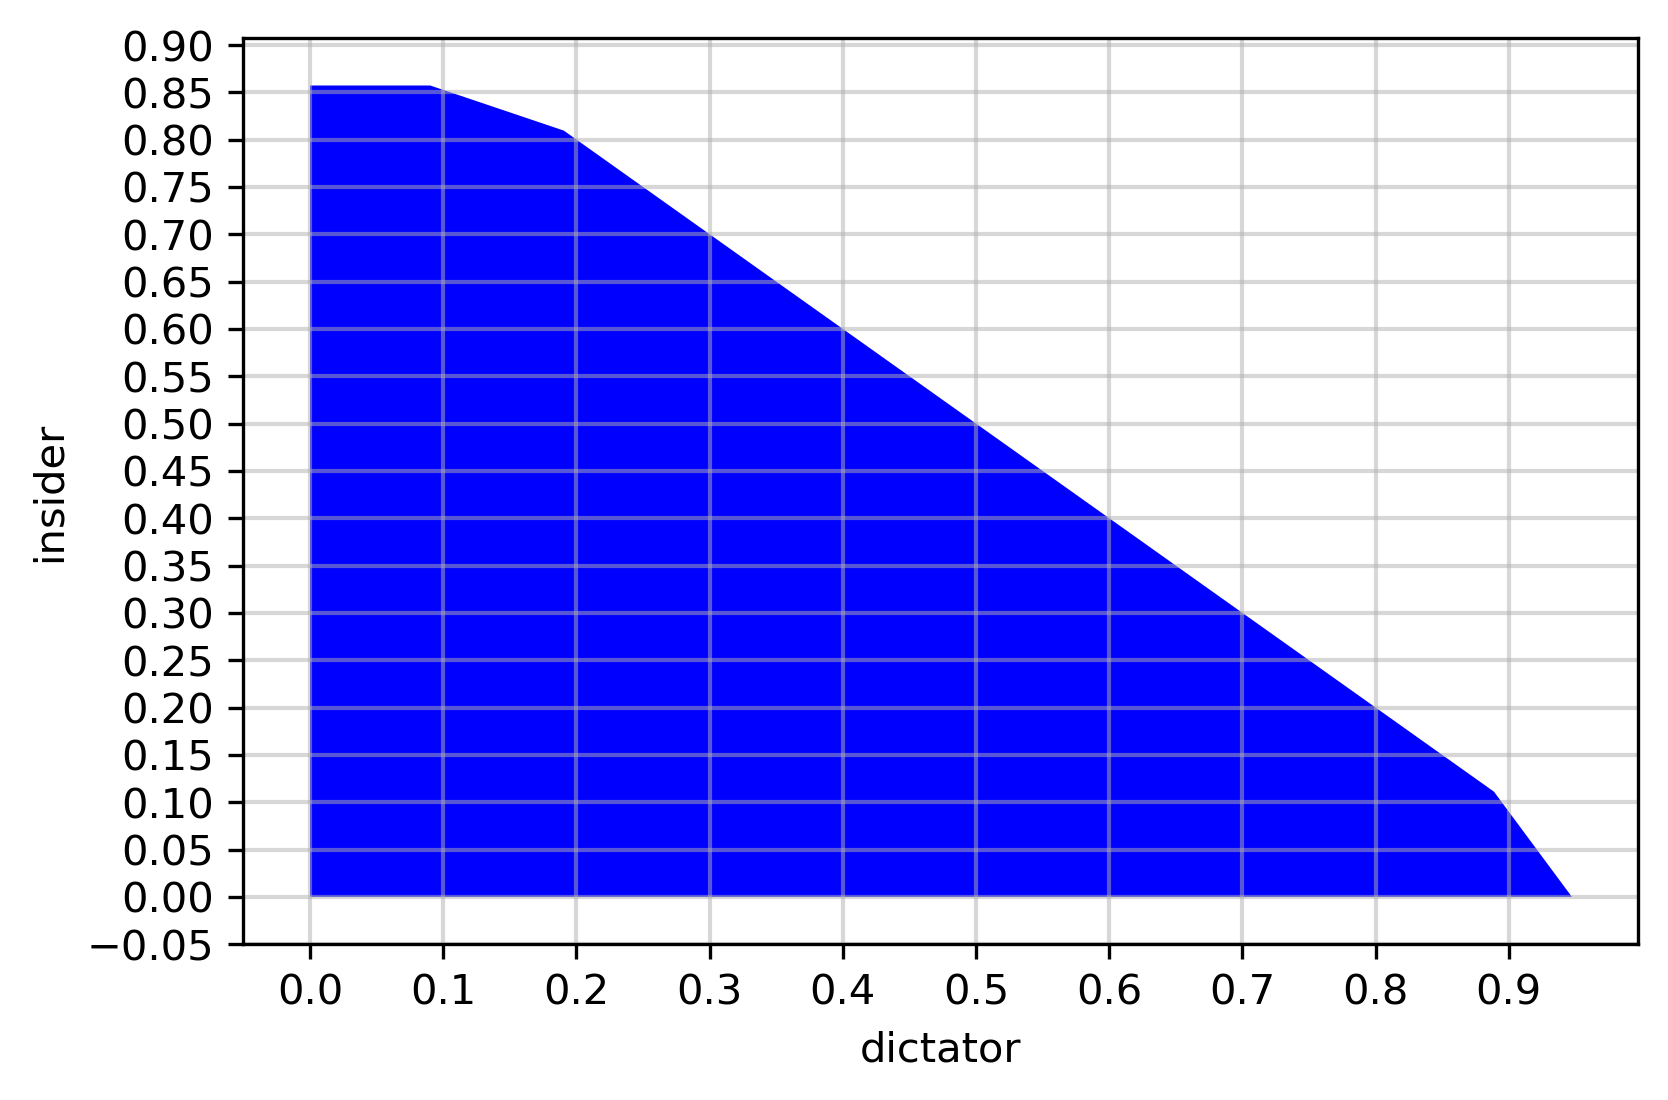

[array([0., 0.]), array([0.94736842, 0.        ]), array([0.88888889, 0.11111111]), array([0.19047619, 0.80952381]), array([0.09022556, 0.85714286]), array([0.        , 0.85714286])]


In [2]:
#Basic linear algebra operations


#ith basis vector
def basis_vector(i,n):
    basis_vector = np.zeros(n)
    basis_vector[i] = 1
    return basis_vector

#vertical ith basis vector
def basis_vector_vertical(i,n):
    vector = basis_vector(i,n)
    res = np.reshape(vector, (len(vector), 1))
    return res
    
    
#vertical unit vector
def unit_vector_vertical(n):
    unit_vector = np.ones(n)
    res = np.reshape(unit_vector, (len(unit_vector), 1))
    return res


#vertical vector b where first 2n^2 coordinates are 0, next n are 1 and next n are -1
def generate_vector_b(n):
    vector_length = 2 * n**2 + 2 * n
    vector = np.zeros(vector_length)
    vector[2 * n**2: 2 * n**2 + n] = 1
    vector[2 * n**2 + n:2 * n**2 + 2 * n] = -1
    res = np.reshape(vector, (len(vector), 1))
    return res


#diagonal matrix with prior probabilities on the main diagonal
def prior_to_matrix_M(mu):
    mu = np.array(mu)
    n = len(mu)
    unit_vector_vertical_kron_mu = np.kron(unit_vector_vertical(n),mu)
    I = np.eye(n)
    res = np.multiply(I, unit_vector_vertical_kron_mu)
    return res
   

#map prior belief and receiver's utiity matrix to matrix Q_i of IC constraints for recommendation a_i
def prior_and_U_to_Q_i(M,U,i):
    n = len(M)
    mat_of_ith_row_of_U = np.kron(unit_vector_vertical(n),U[i])
    res = np.matmul((mat_of_ith_row_of_U - U),M)
    return res


#direct sum of matrices Q_i
def Q_is_to_Q(lst):
    Q = lst[0]
    for i in lst[1:]:
        Q = block_diag(Q, i)
    return Q


#add |\Omega|^2 constraints that probabilities are nonnegative. 
#to do so, add |\Omega|^2 rows where ith coordinate is 1.n = |\Omega|

def add_noneg_constraints(Q,n):
    I = np.eye(n ** 2)
    return np.vstack((Q,I))

def add_sum_up_to_one_constraints(Q,n):
    for i in range(n):
        v = basis_vector(i,n)
        constraint = np.kron(np.ones(n),v)
        Q = np.vstack((Q,constraint))
    for i in range(n):
        v = -basis_vector(i,n)
        constraint = np.kron(np.ones(n),v)
        Q = np.vstack((Q,constraint))
    return Q


#Return the set of extreme points for inequality A.x>= b
#We get an inequality of the form A.x >= b <> -A.x <= -b. 
#In pycddlib documentation we have: for a polyhedron described as P = {x | A x <= b}, 
#the H-representation is the matrix [b -A].
#Hence, we want the matrix [-b A]

def ext_points_mat_vec(A,b):
    M = np.hstack((-b,A)).astype(np.float64)
    mat = cdd.Matrix(M, linear=False, number_type="float") 
    mat.rep_type = cdd.RepType.INEQUALITY
    poly = cdd.Polyhedron(mat)
    ext = poly.get_generators()
    ext_points = [] 
    for row in ext:
        row = list(row)
        row = row[1:]
        ext_points.append(row)
    return ext_points


#list of utility matrices V_i to matrix V
def Vs_to_V(lst):
    rows = len(lst)
    cols = len(lst[0]) * len(lst[0][0])
    V = np.zeros((rows,cols))
    for k in range(len(lst)):
        V_k = lst[k].flatten()
        e_k = basis_vector_vertical(k,len(lst))
        e_k_kron_V_k = np.kron(e_k,V_k)
        V += e_k_kron_V_k
    return V
    

def unit_vector_and_prior_to_m(mu):
    n = len(mu)
    unit_vector = np.ones(n)
    res = np.kron(unit_vector,mu)
    return res


def V_and_P_and_m_to_B_hat(V,P,m):
    B_hat = []
    for p in P:
        v = p * m
        payoff = np.dot(V,v)
        B_hat.append(payoff)
    return B_hat
        
        
def payoff_prior_to_P(U,mu):
    n = len(mu)
    M = prior_to_matrix_M(mu)
    Qis = [prior_and_U_to_Q_i(M,U,i) for i in range(n)]
    Q = Q_is_to_Q(Qis)
    Q = add_noneg_constraints(Q,n)
    Q = add_sum_up_to_one_constraints(Q,n)
    b = generate_vector_b(n)
    P = ext_points_mat_vec(Q,b)
    return P


#example of P generation
#print("This is a simple example of generating the set P of information structures")
#U = np.array([[1,0],[0,1]])
#mu = [0.5,0.5]
#print(payoff_prior_to_P(U,mu))
#print(" ")


def plot_if_2d(B):
    if len(B[0]) > 2:
        return
    for b in B:
        b = list(b)
    B = np.array(B)
    x_coords = B[:, 0]
    y_coords = B[:, 1]
    plt.figure(dpi=300)
    plt.fill(x_coords, y_coords, 'bo-')
    plt.xlim(min(x_coords) - 0.05, max(x_coords) + 0.05)
    plt.ylim(min(y_coords) - 0.05, max(y_coords) + 0.05)
    plt.xlabel('dictator')
    plt.ylabel('insider')
    plt.grid(True, linewidth=1,alpha = 0.5)
    tick_interval = 0.05
    plt.locator_params(axis='both', tight=True, nbins=int(1 / tick_interval))
    plt.savefig('dictins_1.png', dpi=300)
    plt.show()
    
def get_ext_points_vector_set(B):
    B = np.array(B)
    hull = ConvexHull(B)
    ext_points = []
    for v in hull.vertices:
        ext_points.append(B[v])
    return ext_points
    
    

def driver(U,mu,Vs):
    P =  payoff_prior_to_P(U,mu)
    m =  unit_vector_and_prior_to_m(mu)
    V = Vs_to_V(Vs)
    B_hat = V_and_P_and_m_to_B_hat(V,P,m)
    B = get_ext_points_vector_set(B_hat)
    #plot_if_2d(B)
    return B


#example of generating the payoff set
#print("This is a simple example of generating the set of feasible payoffs")
#U = np.array([[1,0],[0,1]])
#V1 = np.array([[1,1],[0,0]])
#V2 = np.array([[0,0],[1,1]])
#Vs = [V1,V2]
#mu = [0.5,0.5]
#driver(U,mu,Vs)


#dictator-insider example
#c = 0.05
#U = np.array([[1,0,0],[-c,1 - c,-c],[-c,-c,1 - c]])
#V1 = np.array([[1,1,1],[0,0,0],[0,0,0]])
#V2 = np.array([[0,0,0],[1,1,1],[0,0,0]])
#Vs = [V1,V2]
#mu = [0.3,0.3,0.4]
#driver(U,mu,Vs)

#plot_if_2d(driver(U,mu,Vs))
#print(driver(U,mu,Vs))


[array([0.7, 1.6]), array([1., 1.]), array([1.6, 0.7]), array([1.2, 1.2])]


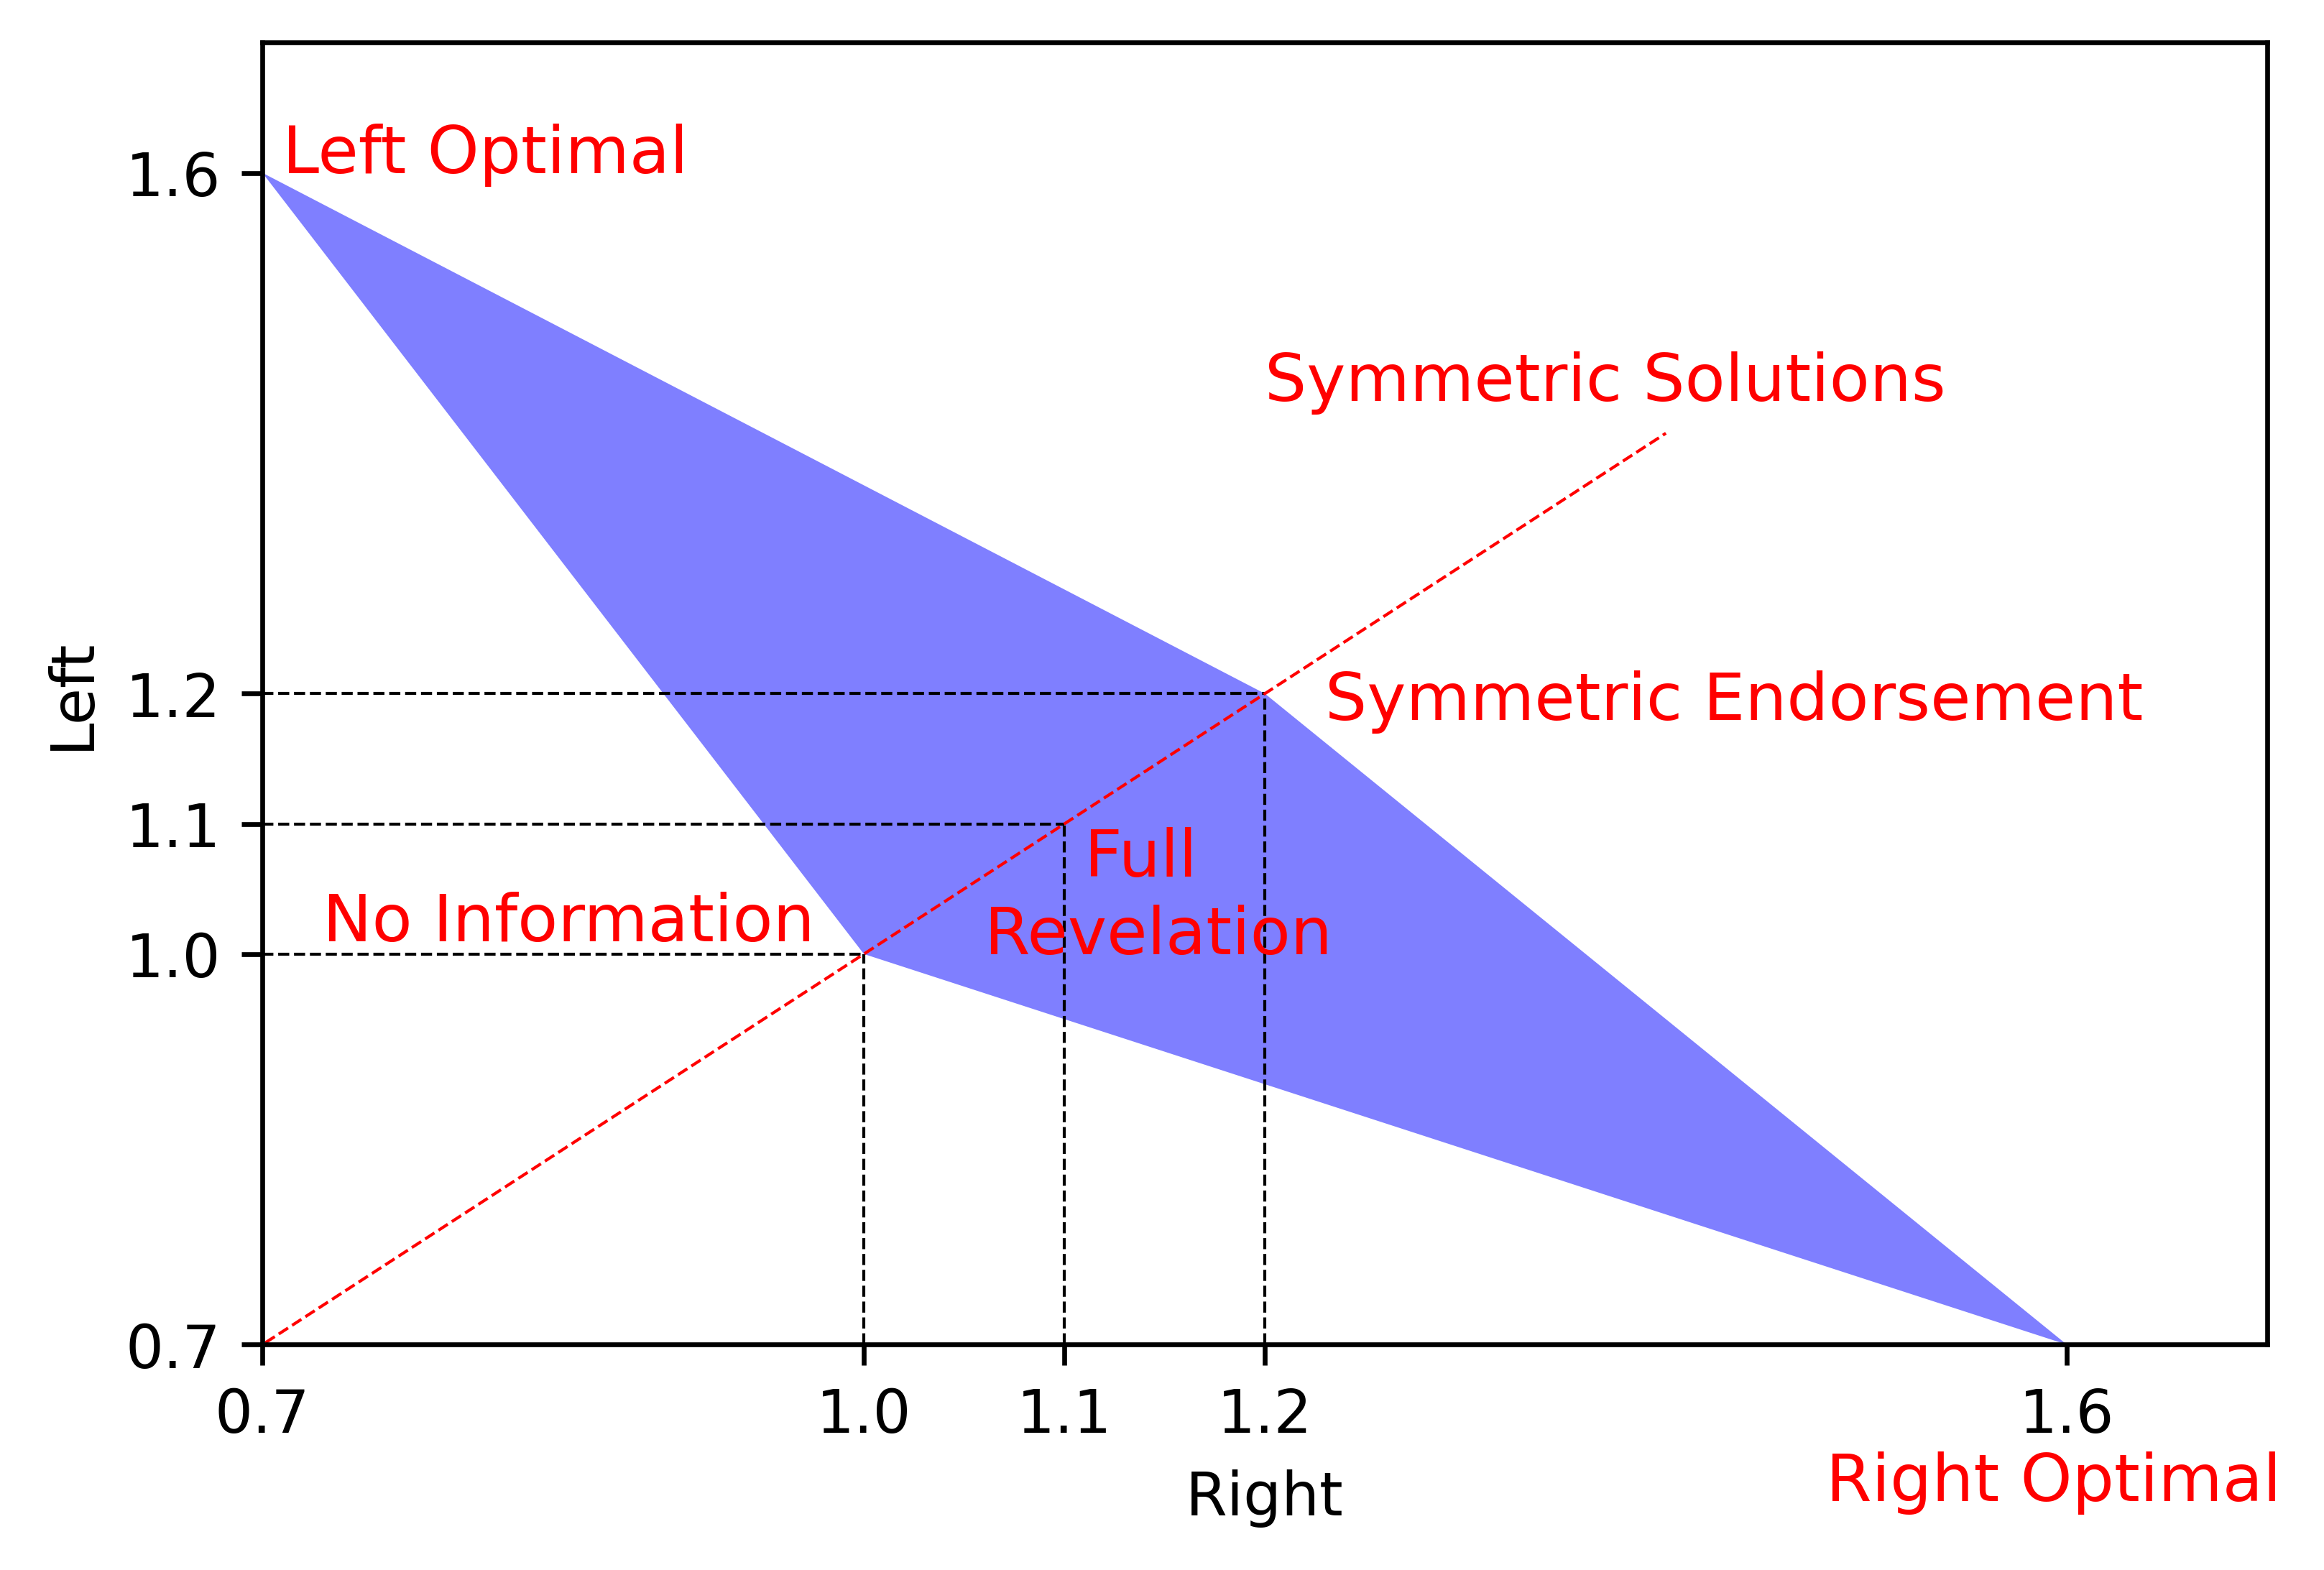

In [29]:
###Election Example ####

UUU = np.array([[1,0,0],[0,1 ,0],[0,0,1]])
VV_left = np.array([[3,3,3],[1,1,1],[0,0,0]])
VV_right = np.array([[0,0,0],[1,1,1],[3,3,3]])
VVs = [VV_left,VV_right]
muu = [0.1,0.8,0.1]
print(driver(UUU,muu,VVs))

pyffpoints = driver(UUU,muu,VVs)

pyffpoints = np.array(pyffpoints)

xsym=np.linspace(0,1.4,101)

y_coords = pyffpoints[:, 0]
x_coords = pyffpoints[:, 1]
plt.figure(dpi=600)
plt.fill(x_coords, y_coords, 'blue',alpha = 0.5)
plt.plot(xsym,xsym,color='r',linewidth=0.5,linestyle='--')
plt.xlim(min(x_coords), max(x_coords) + 0.1)
plt.ylim(min(y_coords), max(y_coords) + 0.1)
plt.ylabel('Left')
plt.xlabel('Right')

plt.xticks([0.7,1,1.1,1.2,max(x_coords)])
plt.yticks([0.7,1,1.1,1.2,max(y_coords)])

plt.text(max(y_coords)-0.4, 1.2+0.225, r'Symmetric Solutions',color='r', fontsize = 11)

plt.hlines(y=1, xmin=0.7, xmax=1, linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=1, ymin=0.7, ymax=1, linewidth=0.5, color='black',linestyle='--')

plt.text(0.73, 1.01, r'No Information',color='r', fontsize = 11)

plt.hlines(y=1.1, xmin=0.7, xmax=1.1, linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=1.1, ymin=0.7, ymax=1.1, linewidth=0.5, color='black',linestyle='--')

plt.text(1.11, 1.06, r'Full',color='r', fontsize = 11)
plt.text(1.06, 1, r'Revelation',color='r', fontsize = 11)

plt.hlines(y=1.2, xmin=0.7, xmax=1.2, linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=1.2, ymin=0.7, ymax=1.2, linewidth=0.5, color='black',linestyle='--')

plt.text(1.23, 1.18, r'Symmetric Endorsement',color='r', fontsize = 11)
#plt.text(1.2, 1.15, r'Endorsement',color='r', fontsize = 11)

plt.text(0.71, 1.6, r'Left Optimal',color='r', fontsize = 11)
plt.text(1.48, 0.58, r'Right Optimal',color='r', fontsize = 11)

plt.savefig('dictins_1.png', dpi=600)
plt.show()

[array([0., 0.]), array([0.94736842, 0.        ]), array([0.88888889, 0.11111111]), array([0.19047619, 0.80952381]), array([0.09022556, 0.85714286]), array([0.        , 0.85714286])]


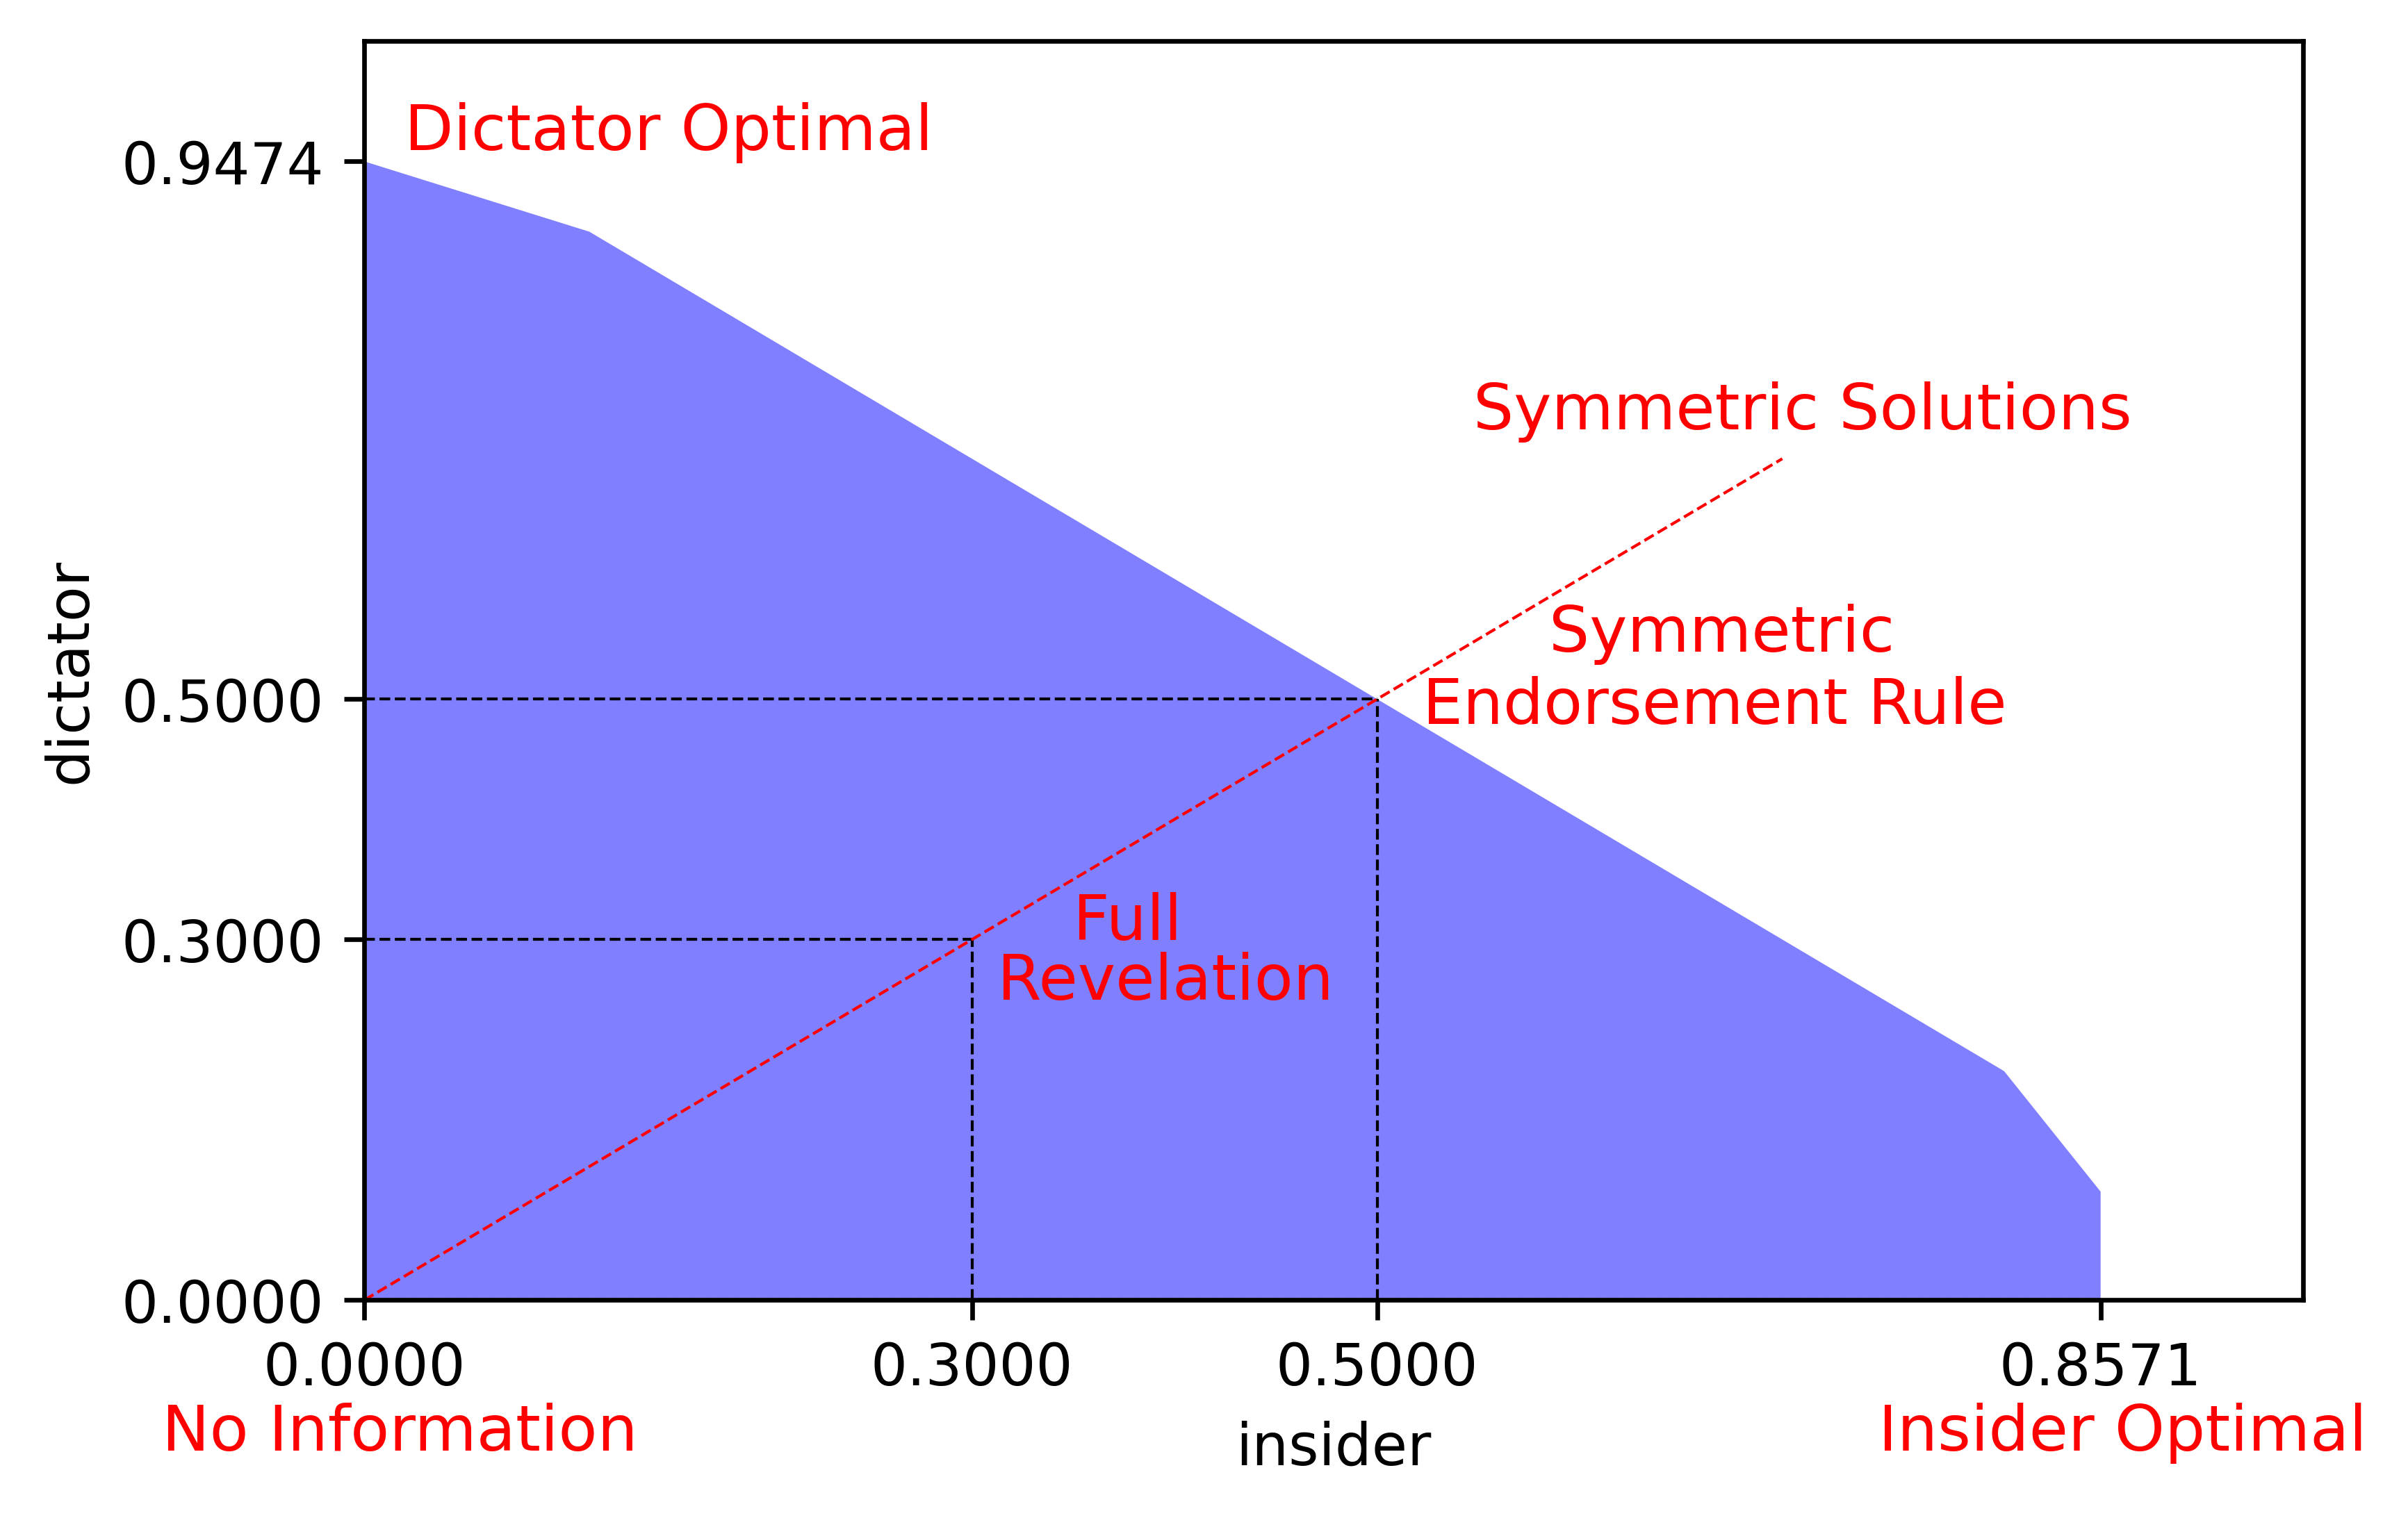

In [4]:
###Dictator - Insider Example ####

cc = 0.05
UUU = np.array([[1,0,0],[-cc,1 - cc,-cc],[-cc,-cc,1 - cc]])
VV1 = np.array([[1,1,1],[0,0,0],[0,0,0]])
VV2 = np.array([[0,0,0],[1,1,1],[0,0,0]])
VVs = [VV1,VV2]
muu = [0.3,0.3,0.4]
print(driver(UUU,muu,VVs))

#payoff points driver(UU,muu,VVs)

pyffpoints = driver(UUU,muu,VVs)

pyffpoints = np.array(pyffpoints)

xsym=np.linspace(0,0.7,100)

y_coords = pyffpoints[:, 0]
x_coords = pyffpoints[:, 1]
plt.figure(dpi=600)
plt.fill(x_coords, y_coords, 'blue',alpha = 0.5)
plt.plot(xsym,xsym,color='r',linewidth=0.5,linestyle='--')
plt.xlim(min(x_coords), max(x_coords) + 0.1)
plt.ylim(min(y_coords), max(y_coords) + 0.1)
plt.ylabel('dictator')
plt.xlabel('insider')
#plt.grid(False, linewidth=1,alpha = 0.5)

plt.text(max(y_coords)-0.4, 0.5+0.225, r'Symmetric Solutions',color='r', fontsize = 11)
plt.text(-0.1, -0.125, r'No Information',color='r', fontsize = 11)

plt.hlines(y=0.3, xmin=0, xmax=0.3, linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=0.3, ymin=0, ymax=0.3, linewidth=0.5, color='black',linestyle='--')

plt.text(0.35, 0.3, r'Full',color='r', fontsize = 11)
plt.text(0.3125, 0.25, r'Revelation',color='r', fontsize = 11)

plt.hlines(y=0.5, xmin=0, xmax=0.5, linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=0.5, ymin=0, ymax=0.5, linewidth=0.5, color='black',linestyle='--')

plt.text(0.585, 0.54, r'Symmetric',color='r', fontsize = 11)
plt.text(0.5225, 0.48, r'Endorsement Rule',color='r', fontsize = 11)

plt.text(0.02, max(y_coords)+0.01, r'Dictator Optimal',color='r', fontsize = 11)
plt.text(max(y_coords)-0.2, -0.125, r'Insider Optimal',color='r', fontsize = 11)

plt.hlines(y=0, xmin=0, xmax=max(x_coords), linewidth=0.5, color='black',linestyle='--')
plt.vlines(x=max(y_coords), ymin=0, ymax=0, linewidth=0.5, color='black',linestyle='--')

plt.xticks([0,0.3,0.5,max(x_coords)])
plt.yticks([0,0.3,0.5,max(y_coords)])

plt.savefig('dictins_1.png', dpi=600)
plt.show()